In [8]:
import json, itertools, glob, random, os, sys
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

from engine.settings import BSC_ROOT_DATA_FOLDER, MODELS_FOLDER

audio_paths = glob.glob(str(BSC_ROOT_DATA_FOLDER / 'manual_peak_1' / 'audio' / 'peaks') + '/*.wav')
labels = ['VS', 'VSV', 'ES', 'SS', 'C1', 'I', 'EC', 'ESS', 'T', 'V_BS', 'V_W2', 'CS']

names = {
	'VS': [
		'2015-07-09_ID8_0051_peak19502_VS_b50_a50.png'
		, '2015-07-09_ID8_0051_peak19375_VS_b50_a50.png'
		, '2015-06-24_ID10_0028_peak40951_VS_b50_a50.png'
		, '2015-06-24_ID10_0028_peak41310_VS_b50_a50.png'
		, '2015-06-24_ID10_0028_peak41978_VS_b50_a50.png'
		, '2015-06-24_ID10_0026_peak18901_VS_b50_a50.png'
	]
	, 'VSV': [
		'2015-06-11_ID8_0096_peak33876_VSV_b50_a50.png'
		, '2015-06-11_ID8_0096_peak33813_VSV_b50_a50.png'
		, '2015-07-09_ID8_0051_peak22744_VSV_b50_a50.png'
		, '2015-07-09_ID8_0051_peak22676_VSV_b50_a50.png'
		, '2015-07-09_ID8_0051_peak22617_VSV_b50_a50.png'
		, '2015-07-09_ID8_0056_peak3450_VSV_b50_a50.png'
	]

	, 'ES': [
		'2015-08-02_ID10_0009_peak32233_ES_b50_a50.png'
		, '2015-08-02_ID10_0009_peak32131_ES_b50_a50.png'
		, '2015-07-22_ID10_0007_peak19104_ES_b50_a50.png'
		, '2015-07-22_ID10_0007_peak44353_ES_b50_a50.png'
		, '2015-07-22_ID10_0007_peak7993_ES_b50_a50.png'
		, '2015-08-02_ID10_0009_peak32131_ES_b50_a50.png'
	]
	, 'SS': [
		''
	]
	, 'C1': [
		'2015-07-08_ID10_0024_peak59982_C1_b50_a50.png'
		, '2015-07-18_ID10_0013_peak56863_C1_b50_a50.png'
		, '2015-07-18_ID10_0013_peak24648_C1_b50_a50.png'
		, '2015-07-18_ID10_0012_peak93271_C1_b50_a50.png'
		, '2015-07-18_ID10_0012_peak93295_C1_b50_a50.png'
		, '2015-07-22_ID10_0009_peak9883_C1_b50_a50.png'
	]
	, 'EC': [

	]
	, 'ESS': [

	]
	, 'T': [

	]
	, 'V_BS': [

	]
}

n_fft = 1024
lag = 2 #distance of frames between two compared frames for onset
window_length = n_fft
hop_length = int(window_length * (1-0.875))
window = 'hamming'

def create_meta(file):
	y, sr = librosa.load(file, sr=500000)
	return {
		'file': file, 'y': y, 'sr':sr, 's':np.abs(librosa.stft(y, n_fft=n_fft, window=window, hop_length=hop_length, win_length=window_length))
	}


files_per_label = dict()
for label in labels:
	# f_image_paths = list(filter(lambda image_path: image_path.find('_' +label+'_') != -1, audio_paths))
	# files_per_label[label] = list(map(create_meta, random.sample(f_image_paths, 5)))
	# files_per_label[label] = list(map(create_meta, f_image_paths[5:10]))

	if label in names:
		images =  names[label]
		if len(images) > 0:

			audio_paths = [path.replace('', '') for path in images]
			list(filter(lambda image_path: image_path.find('_' +label+'_') != -1, audio_paths))

In [6]:
from skimage.morphology import closing, binary_closing, binary_opening
from utils.canny import canny
from skimage.transform import probabilistic_hough_line
from skimage.measure import find_contours, approximate_polygon

def mean_amplitude_per_freq_denoise(data):
	me = np.mean(data, 1)
	data = data - me[:, np.newaxis]
	# remove anything below 0
	data.clip(min=0, out=data)
	return data

offeset_length = 400
sample_offset = librosa.frames_to_samples(offeset_length, hop_length, n_fft)
for label in files_per_label:
	break
	for file_meta in files_per_label[label]:
		s = file_meta['s']
		y = file_meta['y']
		sr = file_meta['sr']

		odf_sf = librosa.onset.onset_strength(S=s, sr=sr, n_fft=n_fft, hop_length=hop_length, lag=2, max_size=1)
		onset_sf = librosa.onset.onset_detect(onset_envelope=odf_sf, sr=sr, hop_length=hop_length, backtrack=True)
		plt.figure(figsize=(10, 8))
		ax = plt.subplot(2, 1, 1)
		librosa.display.specshow(librosa.amplitude_to_db(s, ref=np.max), sr=sr, y_axis='hz', x_axis='time')

		plt.subplot(2, 1, 2)
		plt.plot(librosa.frames_to_time(np.arange(len(odf_sf)), sr=sr, hop_length=hop_length), odf_sf, label='Super flux')
		plt.vlines(librosa.frames_to_time(onset_sf, sr=sr, hop_length=hop_length, n_fft=n_fft), 0, odf_sf.max(), label='Onsets')
		plt.legend()
		plt.tight_layout()

		for onset in onset_sf:
			onset_frame = librosa.frames_to_samples(onset, hop_length, n_fft)
			for onset_part in range(1):
				onset_offset = onset + (380 * onset_part)
				onset_offset_frame = librosa.frames_to_samples(onset_offset, hop_length, n_fft)
				i_onset = s[:,onset_offset:onset_offset+offeset_length]
				y_onset = y[onset_offset_frame:onset_offset_frame+sample_offset]

				edges2 = canny(np.flip(i_onset, 0), sigma=2, low_threshold=0.01, high_threshold=0.8)
				plt.figure(figsize=(16, 15))
				ax3 = plt.subplot(1, 4, 1)
				ax3.imshow(edges2, cmap=plt.cm.gray)
				ax3.axis('off')
				ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)
				edges2 = binary_closing(edges2, selem=np.ones((5,40), dtype=np.uint8))
				ax3 = plt.subplot(1, 4, 2)
				ax3.imshow(edges2, cmap=plt.cm.gray)
				ax3.axis('off')
				ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)
				# edges2 = binary_closing(edges2, selem=np.ones((3,40), dtype=np.uint8))
				# edges2 = binary_opening(edges2, selem=np.ones((3,20), dtype=np.uint8))
				edges2 = binary_opening(edges2, selem=np.ones((2,40), dtype=np.uint8))
				ax3 = plt.subplot(1, 4, 3)
				ax3.imshow(edges2, cmap=plt.cm.gray)
				ax3.axis('off')
				ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

				ax3 = plt.subplot(1, 4, 4)
				ax3.imshow(edges2, cmap=plt.cm.gray)
				ax3.axis('off')

				# Find contours at a constant value of 0.8
				contours = find_contours(edges2, 0.8)

				for n, contour in enumerate(contours):
					ax3.plot(contour[:, 1], contour[:, 0], linewidth=2)

				ax3.axis('image')
				ax3.set_xticks([])
				ax3.set_yticks([])
				plt.show()

				# lines = probabilistic_hough_line(edges2, threshold=10, line_length=100, line_gap=3)
				# ax3.imshow(edges2 * 0)
				# for line in lines:
				# 	p0, p1 = line
				# 	ax3.plot((p0[0], p1[0]), (p0[1], p1[1]))
				# ax3.set_title('Probabilistic Hough')

				# edges2 = feature.canny(edges2, sigma=0)

				h_range = [1, 2, 3, 4, 5]
				tempi = np.mean(librosa.feature.tempogram(y=y_onset, sr=sr), axis=1)
				t_harm = librosa.interp_harmonics(tempi, librosa.tempo_frequencies(len(tempi), sr=sr), h_range)
				plt.figure(figsize=(8, 8))
				plt.subplot(1, 2, 1)
				librosa.display.specshow(librosa.amplitude_to_db(i_onset, ref=np.max), sr=sr, y_axis='hz', x_axis='time')
				plt.subplot(1, 2, 2)
				librosa.display.specshow(t_harm, sr=sr, x_axis='tempo')
				plt.ylabel('Harmonic part: ' + str(onset_part))
				plt.tight_layout()
				plt.show()

	break

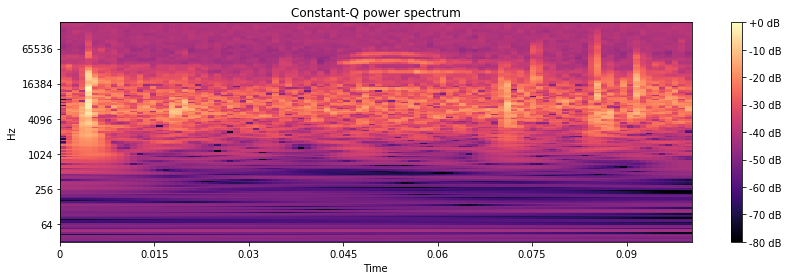

0.00384
0.074752
0.009216
0.046336
0.07808
0.011776
0.043776
0.00384
0.06784
0.01152
0.042752


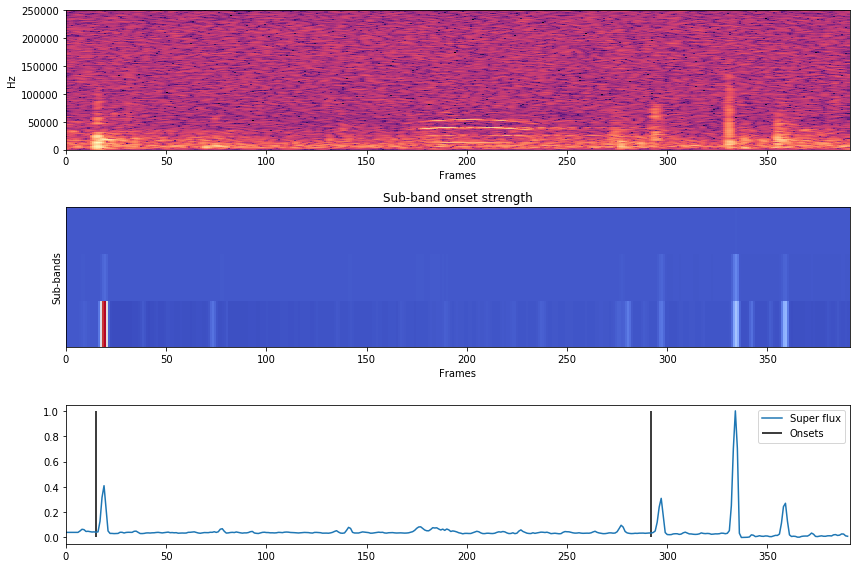

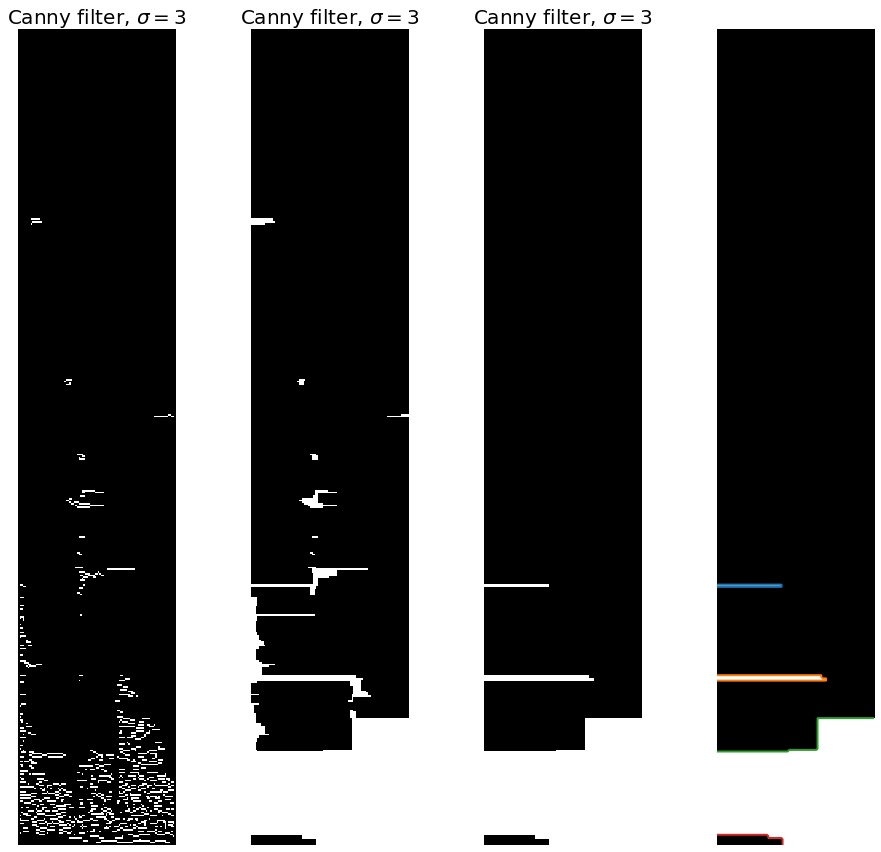

%USERPROFILE%\scoop\apps\miniconda3\current\envs\bat_syllable_classifier\lib\site-packages\librosa\filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
%USERPROFILE%\scoop\apps\miniconda3\current\envs\bat_syllable_classifier\lib\site-packages\librosa\filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
%USERPROFILE%\scoop\apps\miniconda3\current\envs\bat_syllable_classifier\lib\site-packages\librosa\filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(

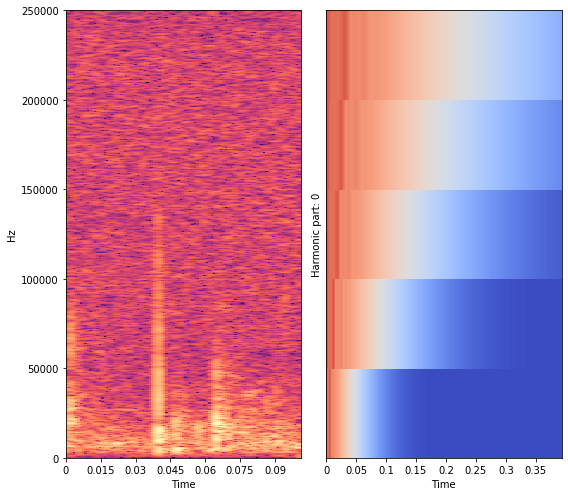

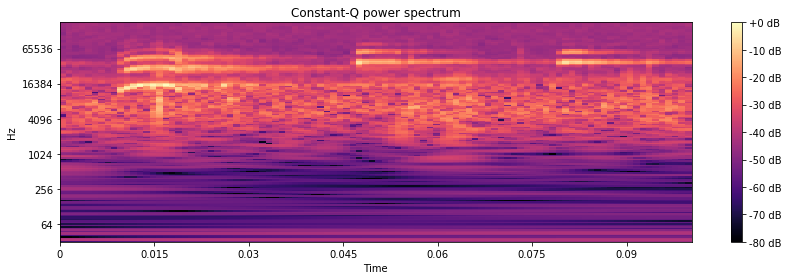

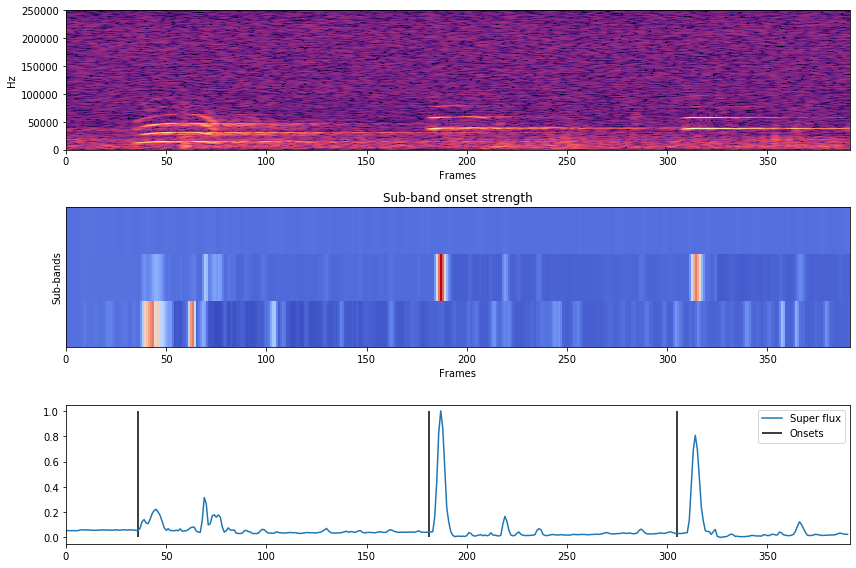

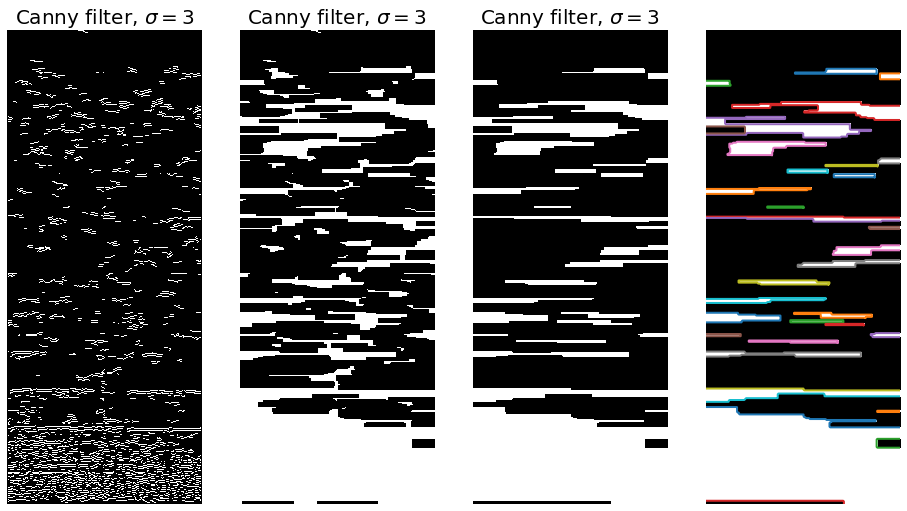

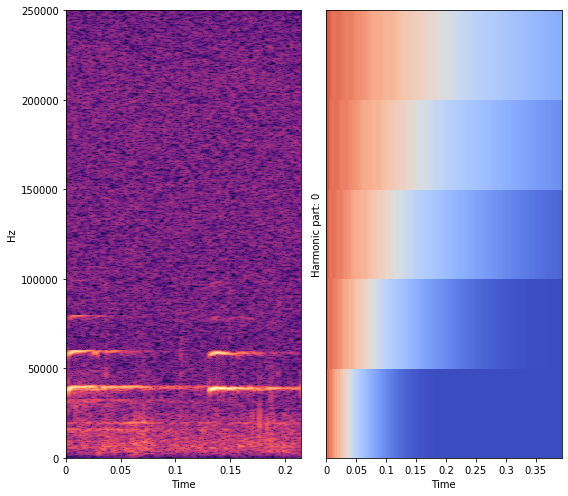

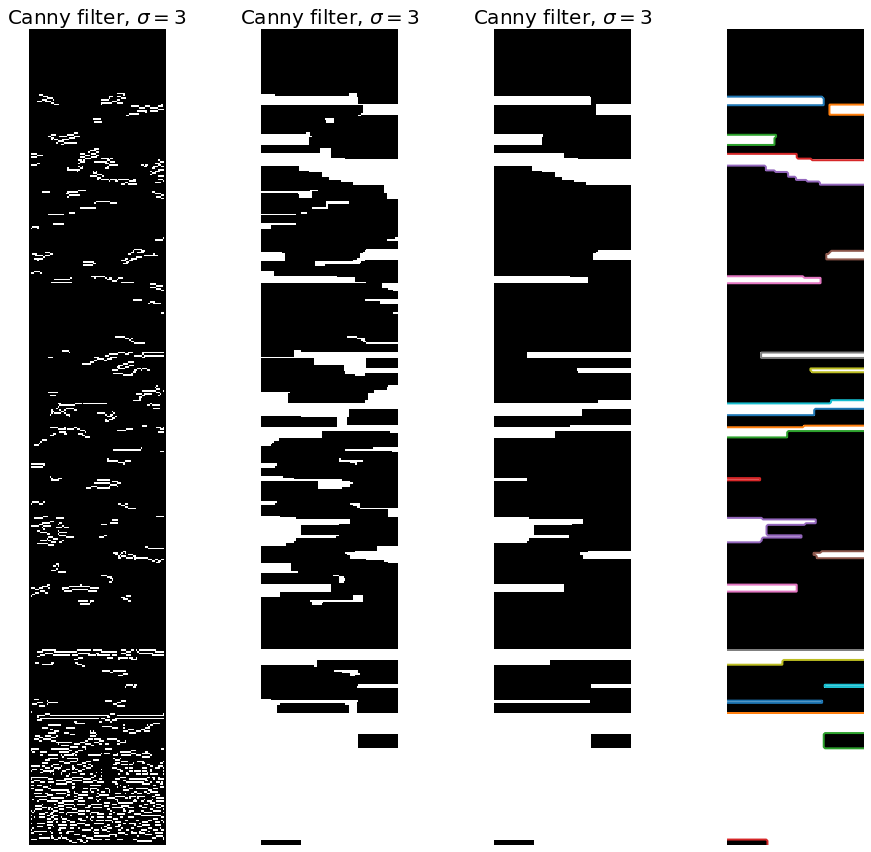

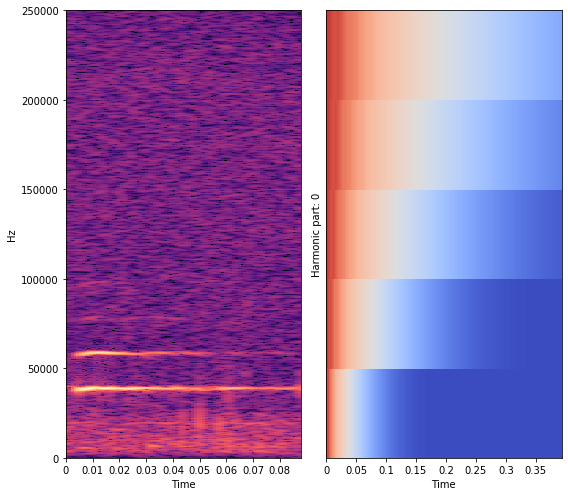

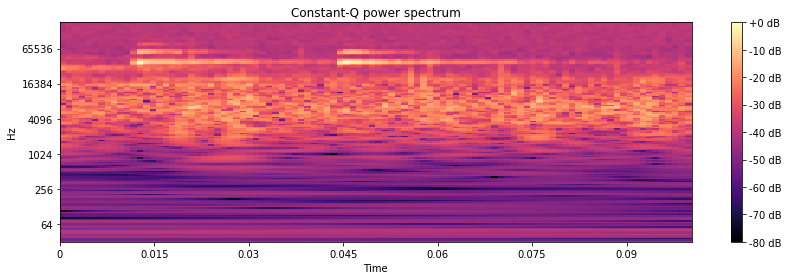

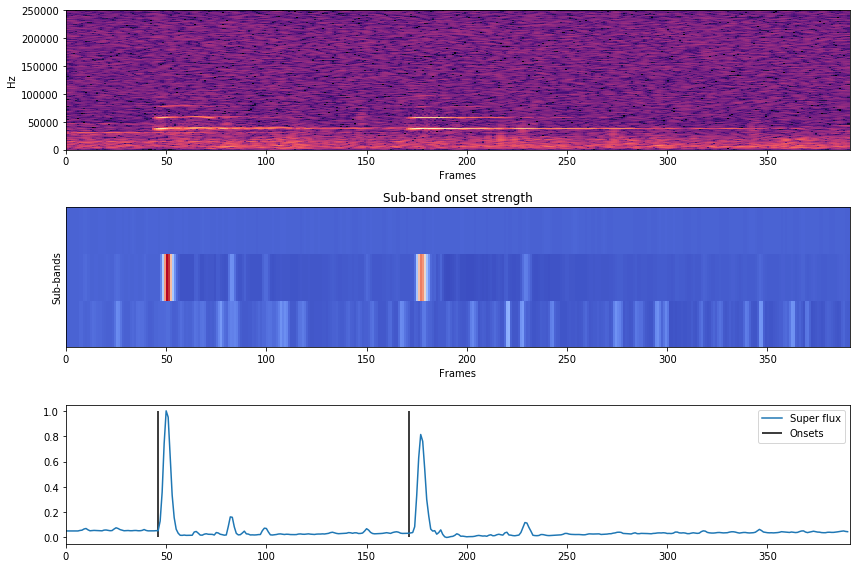

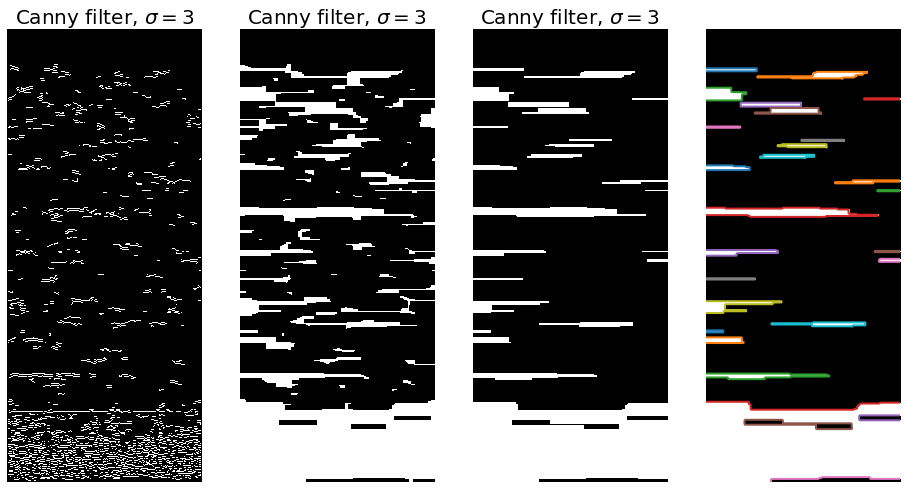

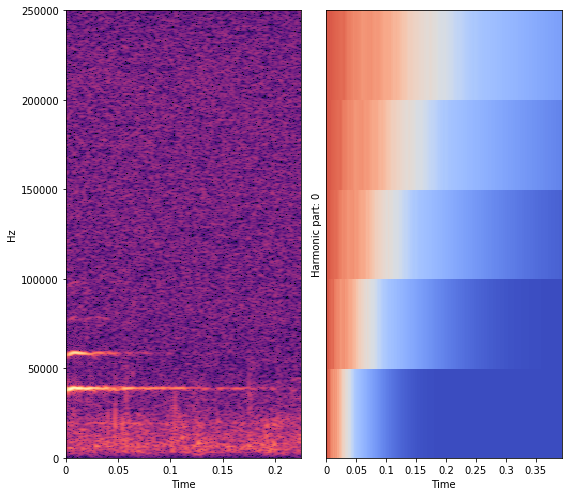

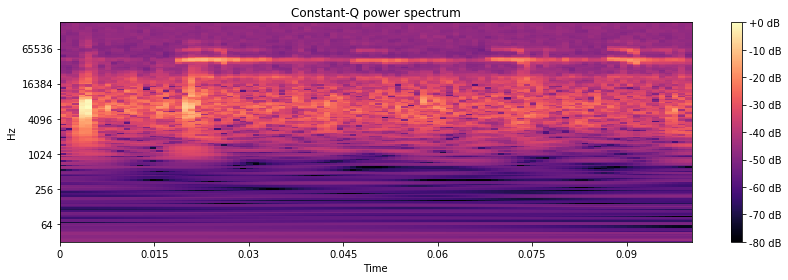

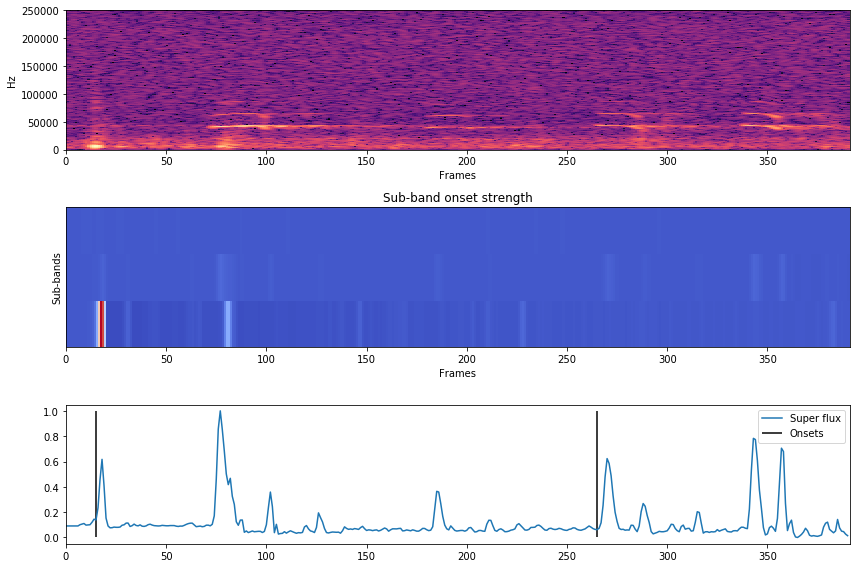

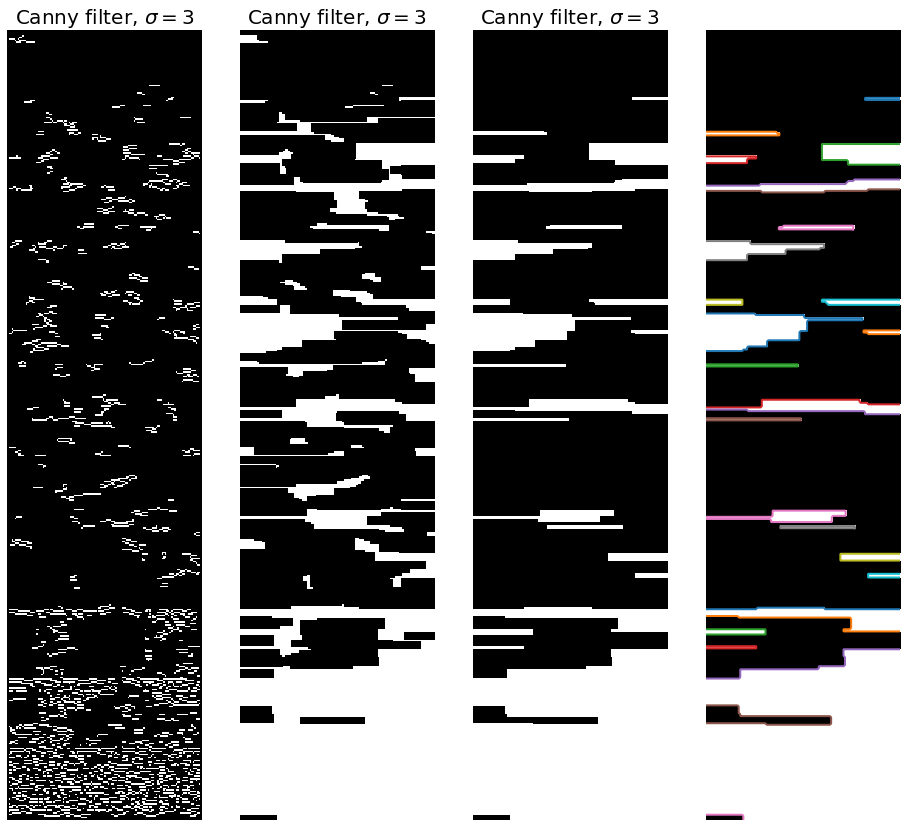

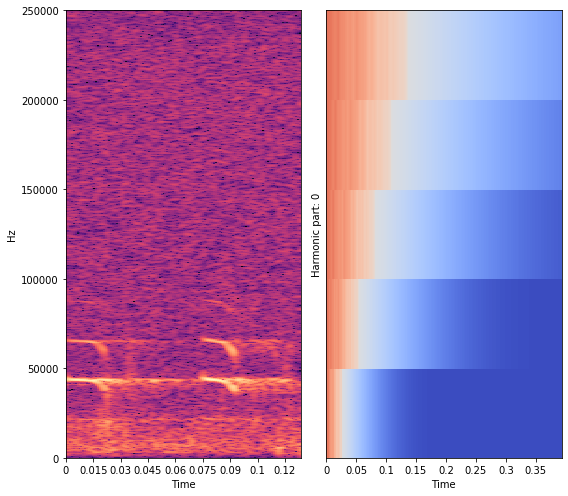

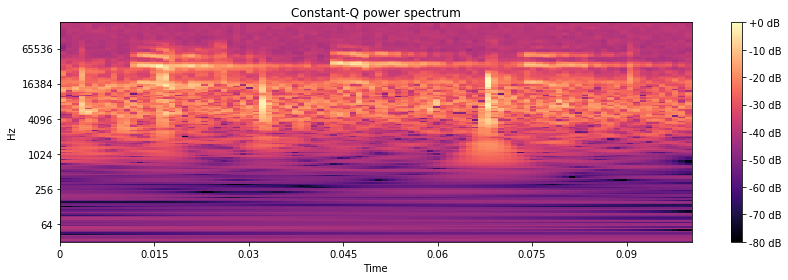

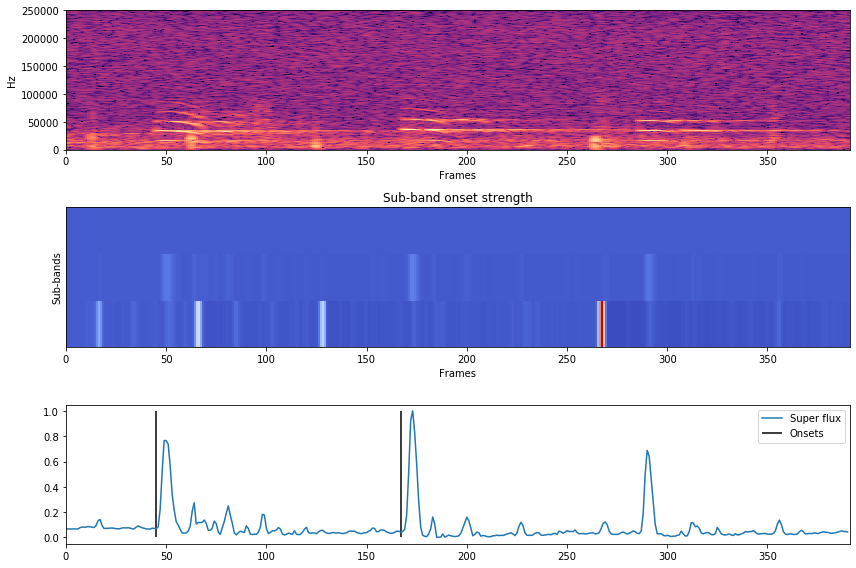

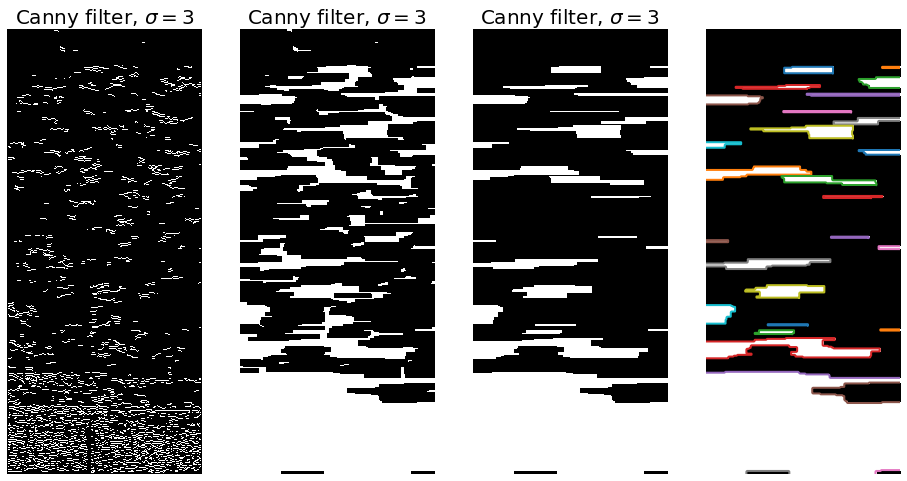

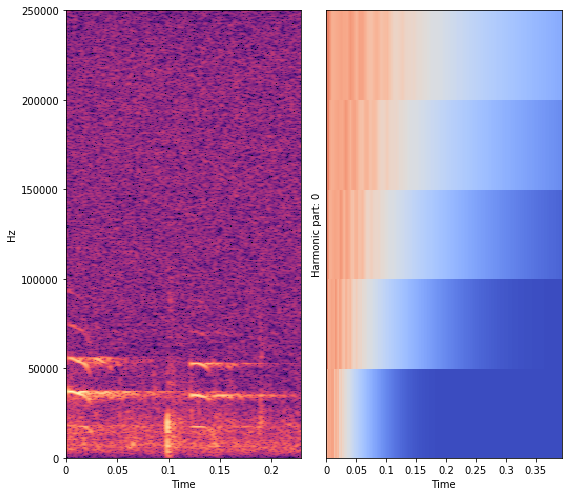

In [9]:
offeset_length = 400
sample_offset = librosa.frames_to_samples(offeset_length, hop_length, n_fft)

for label in files_per_label:
	for file_meta in files_per_label[label]:
		s = file_meta['s']
		y = file_meta['y']
		sr = file_meta['sr']

		cqt = np.abs(librosa.hybrid_cqt(y, sr=sr, bins_per_octave=12, n_bins=12*12+6))
		plt.figure(figsize=(12, 4))
		librosa.display.specshow(librosa.amplitude_to_db(cqt, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_hz')
		plt.colorbar(format='%+2.0f dB')
		plt.title('Constant-Q power spectrum')
		plt.tight_layout()
		plt.show()
		plt.figure(figsize=(12, 8))
		ax = plt.subplot(3, 1, 1)
		librosa.display.specshow(librosa.amplitude_to_db(s, ref=np.max), sr=sr, y_axis='hz', x_axis='frames')

		onset_subbands = librosa.onset.onset_strength_multi(S=s, sr=sr, channels=[0,64,256,512], n_fft=n_fft, hop_length=hop_length, lag=3, max_size=12, detrend=True)
		plt.subplot(3, 1, 2)
		librosa.display.specshow(onset_subbands, x_axis='frames')
		plt.ylabel('Sub-bands')
		plt.title('Sub-band onset strength')

		odf_sf = onset_subbands[1]
		onset_sf = librosa.onset.onset_detect(onset_envelope=odf_sf, sr=sr, hop_length=hop_length, backtrack=True)

		plt.subplot(3, 1, 3, sharex=ax)
		# plt.plot(librosa.frames_to_time(np.arange(len(s[0])), sr=sr, hop_length=hop_length), odf_sf, label='Super flux')
		# plt.vlines(librosa.frames_to_time(onset_sf, sr=sr, hop_length=hop_length), 0, odf_sf.max(), label='Onsets')
		plt.plot(np.arange(len(s[0])), odf_sf, label='Super flux')
		plt.vlines(onset_sf, 0, odf_sf.max(), label='Onsets')
		plt.legend()
		plt.tight_layout()
		for onset in onset_sf:
			onset_time = librosa.frames_to_time(onset, sr, hop_length)
			print(onset_time)
			if onset_time<.02 or onset_time>0.30: continue

			onset_frame = librosa.frames_to_samples(onset, hop_length, n_fft)
			for onset_part in range(1):
				onset_offset = onset + (380 * onset_part)
				onset_offset_frame = librosa.frames_to_samples(onset_offset, hop_length, n_fft)
				i_onset = s[:,onset_offset:onset_offset+offeset_length]
				y_onset = y[onset_offset_frame:onset_offset_frame+sample_offset]

				edges2 = canny(np.flip(i_onset, 0), sigma=2, low_threshold=0.01, high_threshold=0.8)
				plt.figure(figsize=(16, 15))
				ax3 = plt.subplot(1, 4, 1)
				ax3.imshow(edges2, cmap=plt.cm.gray)
				ax3.axis('off')
				ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)
				edges2 = binary_closing(edges2, selem=np.ones((5,40), dtype=np.uint8))
				ax3 = plt.subplot(1, 4, 2)
				ax3.imshow(edges2, cmap=plt.cm.gray)
				ax3.axis('off')
				ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)
				# edges2 = binary_closing(edges2, selem=np.ones((3,40), dtype=np.uint8))
				# edges2 = binary_opening(edges2, selem=np.ones((3,20), dtype=np.uint8))
				edges2 = binary_opening(edges2, selem=np.ones((2,40), dtype=np.uint8))
				ax3 = plt.subplot(1, 4, 3)
				ax3.imshow(edges2, cmap=plt.cm.gray)
				ax3.axis('off')
				ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

				ax3 = plt.subplot(1, 4, 4)
				ax3.imshow(edges2, cmap=plt.cm.gray)
				ax3.axis('off')

				# Find contours at a constant value of 0.8
				contours = find_contours(edges2, 0.8)

				for n, contour in enumerate(contours):
					ax3.plot(contour[:, 1], contour[:, 0], linewidth=2)

				ax3.axis('image')
				ax3.set_xticks([])
				ax3.set_yticks([])
				plt.show()

				# lines = probabilistic_hough_line(edges2, threshold=10, line_length=100, line_gap=3)
				# ax3.imshow(edges2 * 0)
				# for line in lines:
				# 	p0, p1 = line
				# 	ax3.plot((p0[0], p1[0]), (p0[1], p1[1]))
				# ax3.set_title('Probabilistic Hough')

				# edges2 = feature.canny(edges2, sigma=0)

				h_range = [1, 2, 3, 4, 5]
				tempi = np.mean(librosa.feature.tempogram(y=y_onset, sr=sr), axis=1)
				t_harm = librosa.interp_harmonics(tempi, librosa.tempo_frequencies(len(tempi), sr=sr), h_range)
				plt.figure(figsize=(8, 7))
				plt.subplot(1, 2, 1)
				librosa.display.specshow(librosa.amplitude_to_db(i_onset, ref=np.max), sr=sr, y_axis='hz', x_axis='time')
				plt.subplot(1, 2, 2)
				librosa.display.specshow(t_harm, sr=sr, x_axis='time')
				plt.ylabel('Harmonic part: ' + str(onset_part))
				plt.tight_layout()
				plt.show()
	break

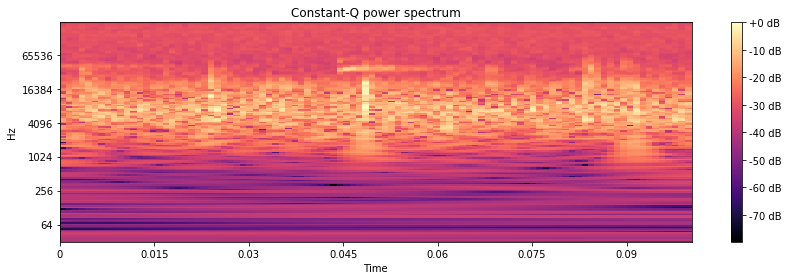

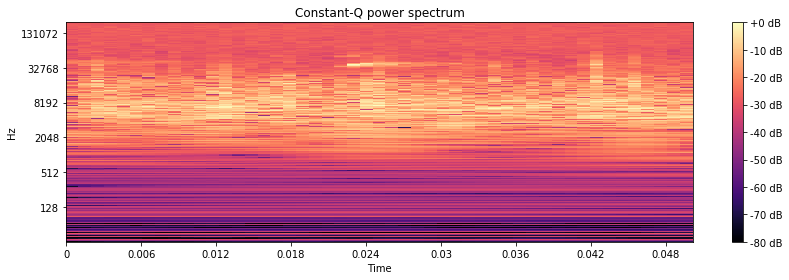

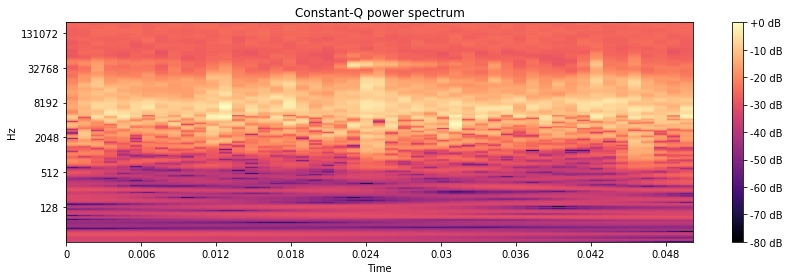

In [2]:
offeset_length = 400
sample_offset = librosa.frames_to_samples(offeset_length, hop_length, n_fft)
BINS_PER_OCTAVE = 12*3


for label in files_per_label:
	for file_meta in files_per_label[label]:
		s = file_meta['s']
		y = file_meta['y']
		sr = file_meta['sr']

		cqt = np.abs(librosa.hybrid_cqt(y, sr=sr, window='hann', bins_per_octave=12, n_bins=12*12+11, scale=True))
		plt.figure(figsize=(12, 4))
		librosa.display.specshow(librosa.amplitude_to_db(cqt, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_hz')
		plt.colorbar(format='%+2.0f dB')
		plt.title('Constant-Q power spectrum')
		plt.tight_layout()
		plt.show()

		cqt = np.abs(librosa.hybrid_cqt(y, sr=sr, hop_length=1024, window='hamming', bins_per_octave=BINS_PER_OCTAVE, n_bins=BINS_PER_OCTAVE*12+21, scale=True, sparsity=0.01))
		plt.figure(figsize=(12, 4))
		librosa.display.specshow(librosa.amplitude_to_db(cqt, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_hz', bins_per_octave=BINS_PER_OCTAVE)
		plt.colorbar(format='%+2.0f dB')
		plt.title('Constant-Q power spectrum')
		plt.tight_layout()
		plt.show()


		cqt = np.abs(librosa.hybrid_cqt(y, sr=sr, hop_length=1024, window='hamming', bins_per_octave=BINS_PER_OCTAVE, n_bins=BINS_PER_OCTAVE*12+21, scale=True, sparsity=0.01, filter_scale=0.2))
		plt.figure(figsize=(12, 4))
		librosa.display.specshow(librosa.amplitude_to_db(cqt, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_hz', bins_per_octave=BINS_PER_OCTAVE)
		plt.colorbar(format='%+2.0f dB')
		plt.title('Constant-Q power spectrum')
		plt.tight_layout()
		plt.show()
		break
	break